In [1]:
import warnings
import os

warnings.filterwarnings('ignore')
os.environ["CUDA_VISIBLE_DEVICES"] = '0'

In [2]:
import itertools
import time

import jax
import jax.numpy as jnp
from jax import random
from jax.experimental import sparse as jsparse
from jax.lax import scan, dot_general
import jax.nn as jnn

import optax
import numpy as np
import matplotlib.pyplot as plt

from data import dataset_LLT
from conj_grad import ConjGrad, apply_LLT
from loss import LLT_loss
from model import MessagePassing, FullyConnectedNet, PrecNet
from train import train, compute_loss_LLT
from utils import params_count

# Make dataset

In [3]:
grid = 32
N_samples = 32
h = 1. / grid

In [4]:
A_train, b_train, u_exact_train, bi_edges_train, nodes_train, edges_train, receivers_train, senders_train = dataset_LLT(grid, N_samples, seed=42)
A_test, b_test, u_exact_test, bi_edges_test, nodes_test, edges_test, receivers_test, senders_test = dataset_LLT(grid, 4, seed=43)

2024-03-05 16:27:19.930447: W external/xla/xla/service/gpu/nvptx_compiler.cc:744] The NVIDIA driver's CUDA version is 12.2 which is older than the ptxas CUDA version (12.3.107). Because the driver is older than the ptxas version, XLA is disabling parallel compilation, which may slow down compilation. You should update your NVIDIA driver or use the NVIDIA-provided CUDA forward compatibility packages.


# Train model

In [5]:
seed = 42
NodeEncoder = FullyConnectedNet(features=[1, 16, 16], N_layers=2, key=random.PRNGKey(seed))
EdgeEncoder = FullyConnectedNet(features=[1, 16, 16], N_layers=2, key=random.PRNGKey(seed))
EdgeDecoder = FullyConnectedNet(features=[16, 16, 1], N_layers=2, key=random.PRNGKey(seed))

mp_rounds = 5
MessagePass = MessagePassing(
    update_edge_fn = FullyConnectedNet(features=[48, 16, 16], N_layers=2, key=random.PRNGKey(seed)),    
    update_node_fn = FullyConnectedNet(features=[48, 16, 16], N_layers=2, key=random.PRNGKey(seed)),
    mp_rounds=mp_rounds
)

model = PrecNet(NodeEncoder=NodeEncoder, EdgeEncoder=EdgeEncoder, 
                EdgeDecoder=EdgeDecoder, MessagePass=MessagePass)
params_count(model)

3009

In [6]:
# c = x.shape[0] // optimization_specification['batch_size']
# keys = [value * c for value in np.arange(50, 1000, 50)]
# values = [0.5, ] * len(keys)
# dict_lr = dict(zip(keys, values))

# sc = optax.piecewise_constant_schedule(optimization_specification['learning_rate'], dict_lr)

In [7]:
X_train = (nodes_train, edges_train, receivers_train, senders_train, bi_edges_train, u_exact_train, b_train)
X_test = (nodes_test, edges_test, receivers_test, senders_test, bi_edges_test, u_exact_test, b_test)
data = (X_train, X_test, jnp.array([1]), jnp.array([1]))

train_config = {'optimizer': optax.nadam,
                'lr': 1e-3,
                'optim_params': {},#{'weight_decay': 1e-8}, 
                'epoch_num': 400}
model, losses = train(model, data, train_config, compute_loss_LLT)

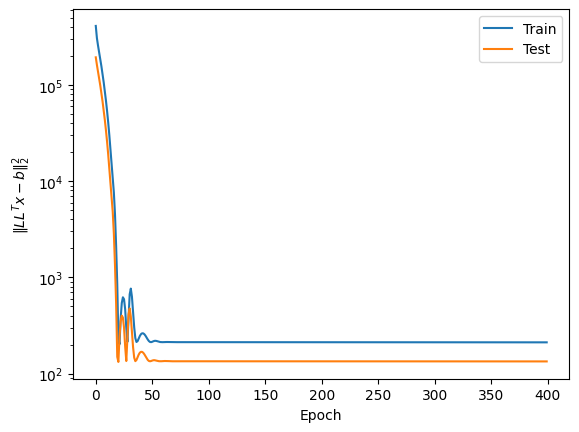

In [8]:
plt.plot(range(len(losses[0])), losses[0], label='Train')
plt.plot(range(len(losses[0])), losses[1], label='Test')
plt.legend()
plt.yscale('log')
plt.xlabel('Epoch')
plt.ylabel('$\|LL^Tx - b\|_2^2$');

# Apply model to CG

In [9]:
# Not preconditioned
data_cg_train = (A_train, b_train, u_exact_train, nodes_train, edges_train, receivers_train, senders_train, bi_edges_train)
_, R_I, X_I, _ = ConjGrad(data_cg_train, N_iter=50, model=None, prec_func=None, m_max=None, seed=42)

In [10]:
# Apply LLT model
data_cg_train = (A_train, b_train, u_exact_train, nodes_train, edges_train, receivers_train, senders_train, bi_edges_train)
_, R_LLT, X_LLT, _ = ConjGrad(data_cg_train, N_iter=50, model=model, prec_func=apply_LLT, m_max=None, seed=42)

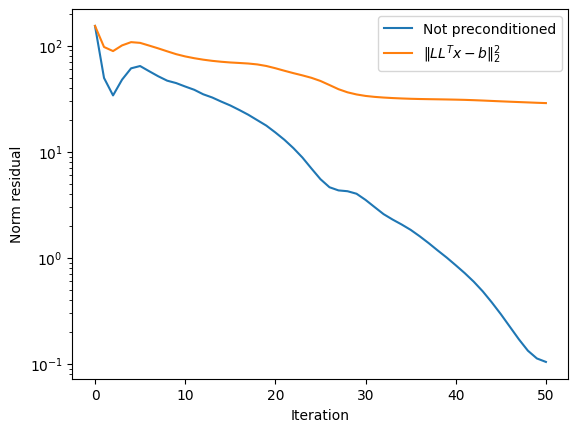

In [11]:
plt.plot(range(R_I.shape[-1]), jnp.linalg.norm(R_I, axis=1).mean(0), label="Not preconditioned")
plt.plot(range(R_LLT.shape[-1]), jnp.linalg.norm(R_LLT, axis=1).mean(0), label="$\|LL^Tx - b\|_2^2$")

# plt.plot(range(20), jnp.linalg.norm(R_I, axis=1).mean(0)[:20], label="Not preconditioned")
# plt.plot(range(20), jnp.linalg.norm(R_LLT, axis=1).mean(0)[:20], label="$\|LL^Tx - b\|_2^2$")
plt.xlabel('Iteration')
plt.ylabel('Norm residual')
plt.legend();
plt.yscale('log');

In [12]:
# h = 1. / grid
# .reshape(-1, grid**2)*h**2

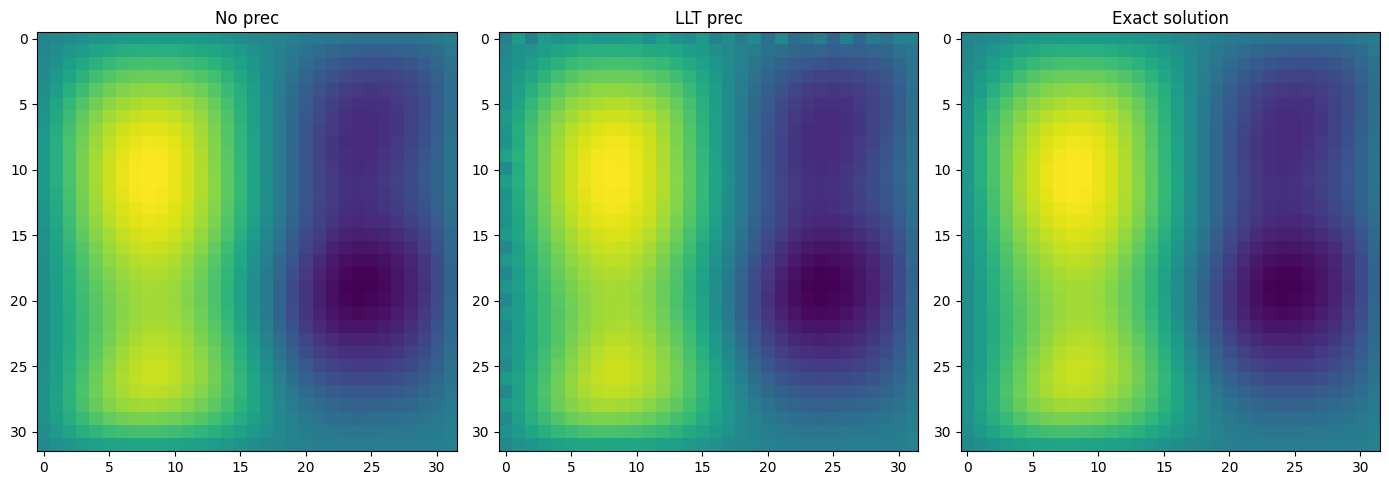

In [13]:
_, axes = plt.subplots(1, 3, figsize=(14, 14))

axes[0].imshow(X_I[0, :, -1].reshape([grid]*2))
axes[1].imshow(X_LLT[0, :, -1].reshape([grid]*2))
axes[2].imshow(u_exact_train[0, :].reshape([grid]*2))

axes[0].set_title('No prec')
axes[1].set_title('LLT prec')
axes[2].set_title('Exact solution')

plt.tight_layout()